In [39]:
import pandas as pd
import numpy as np
import country_converter as coco
import re
import pandas_profiling as pp
import pymysql
from sqlalchemy import create_engine
import getpass
import math
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [40]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

### Importing the data

In [41]:
%store -r data

In [42]:
data2 = data[~data['polity'].isna()]

In [43]:
data2.head()

,continent,region,iso3,country_name,indicator_id,value,democ,autoc,polity,indicator_name,dimension
0,Asia,Southern Asia,AFG,Afghanistan,1,0.0,1.0,2.0,-1.0,European Union Membership (True/False),International Organisations
1,Asia,Southern Asia,AFG,Afghanistan,2,1.0,1.0,2.0,-1.0,United Nations Membership (True/False),International Organisations
2,Asia,Southern Asia,AFG,Afghanistan,3,0.0,1.0,2.0,-1.0,OECD Membership (True/False),International Organisations
3,Asia,Southern Asia,AFG,Afghanistan,21806,2621.1,1.0,2.0,-1.0,Refugees by country of origin (thousands),Human Security
4,Asia,Southern Asia,AFG,Afghanistan,23806,25.1,1.0,2.0,-1.0,Population with at least some secondary educat...,Education


### Filtering Data

In [44]:
%store -r clean_id

In [45]:
clean_data = data2[data2['indicator_id'].isin(clean_id)].copy()
clean_data['indicator_id'] = clean_data['indicator_id'].astype('str')
clean_df = clean_data.pivot(index = ['country_name', 'continent', 'region', 'polity'], 
                                    columns= ['indicator_id'], values = 'value').reset_index().copy()

I only want the indicator_ids that do not have high collinearity with eachother, so I filter them based on the list I created in the previous notebook. 

In [46]:
clean_df.isna().sum()

indicator_id
country_name     0
continent        0
region           0
polity           0
1                0
100806           0
101406          40
101706          21
102006          67
110806           0
110906           0
111106           9
111306          15
117806          67
117906          67
118006          67
121106           0
121206           0
122006           0
123406           7
123506           2
123806          13
127606          13
128106           8
128306           4
132706           0
133006          24
133206           4
135106          22
137906          12
138806          22
140606           0
142506          67
143306           6
146206           2
147206          38
147906          57
148206           0
149406           1
150706           0
164406          19
167106          80
169706           0
169806           0
170106          45
174406           4
175106           0
175206          42
175506          27
175706          13
177106           1
177206           0

## Predicting function:

In [47]:
def predict(df):
    
    # First, I get the names of all the columns that contain NaN values into a list. 
    # I start by looking for the number of NaN values per indicator and I sort them in ascending order,
    # so I will start predicting with the ones that have fewer NaNs.
    
    nan = df.isna().sum().sort_values()
    nan = pd.DataFrame(nan).reset_index()
    nan.columns = ['indicator_id', 'nans']
    nans = []
    
    # I define the length of the column in a list so I can iterate on its range
    
    lst = nan['indicator_id'].to_list()
    
    # With a for loop, I append all the column names with NaN values greater than 0 into a list, in the desired order. 

    for i in range(len(lst)):
        if nan['nans'][i] > 0:
            nans.append(nan['indicator_id'][i])
    
    # I iterate on the nans list, creating a dataframe with only the numerical data and dropping the NaNs. 
    # After that, I re-append the one where I will be predicting (it was dropped because it has NaNs).
    
    for i in nans:
        
        num = df.select_dtypes(np.number).dropna(axis = 1)
        num[i] = df[i]
        
        # I create my training sample with the values for which my column is not NaN, I do an X/y split and I encode the X.
        
        id_with_num = num[num[i].notna()]
        X_id = id_with_num.drop([i],axis=1)
        y_id = id_with_num[i]
        X_normalized_id = pd.DataFrame(MinMaxScaler().fit_transform(X_id), columns=X_id.columns)
        
        # I fit my model into the train sample.
        
        LR = LinearRegression()
        LR.fit(X_normalized_id, y_id)
        
        # I create a second dataframe with all the values (including NaNs), this will be my test sample. 
        # I X/y split, scale and use the model to predict the y. 
        
        X_all = num.drop([i],axis=1)
        X_normalized_all = pd.DataFrame(MinMaxScaler().fit_transform(X_all), columns=X_all.columns)
        y_all = num[i]
        
        # I create a new column with the predictions.
        
        i_pred = pd.Series(LR.predict(X_normalized_all), name='predicted_' + i)
        df = pd.concat([df, i_pred], axis=1)
        
        # In the last column, I get the data frrom the original column and fill the NaNs with the prediction column. 
        # Then I drop the other 2, and now I have no NaN values in the dataframe and I haven't lost any data. 
        
        df['final_' + i] =  np.where(df[i].isna(), df['predicted_' + i], df[i])
        df.drop([i, 'predicted_' + i], axis = 1, inplace = True)
        
    return df

In [48]:
clean_KNN = predict(clean_df)
clean_KNN.isna().sum()

country_name    0
continent       0
region          0
polity          0
1               0
100806          0
110806          0
110906          0
121106          0
121206          0
122006          0
132706          0
140606          0
148206          0
150706          0
169706          0
169806          0
175106          0
177206          0
181606          0
182206          0
2               0
21806           0
27706           0
3               0
31706           0
43006           0
45106           0
46006           0
48706           0
48806           0
49006           0
64306           0
64406           0
69206           0
final_181706    0
final_149406    0
final_177106    0
final_146206    0
final_123506    0
final_53506     0
final_128306    0
final_174406    0
final_133206    0
final_178306    0
final_143306    0
final_123406    0
final_128106    0
final_65606     0
final_24106     0
final_61006     0
final_111106    0
final_52606     0
final_63206     0
final_137906    0
final_1757

Everything looks good, so I run my model on this new df.

In [289]:
X = clean_KNN.drop(['polity', 'country_name', 'region'],axis=1)
y = clean_KNN['polity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.145, 
                                                    random_state = 100)
numericals_train = X_train.select_dtypes(np.number)
numericals_test = X_test.select_dtypes(np.number)

categoricals_train = X_train.select_dtypes(object)
categoricals_test = X_test.select_dtypes(object)

transformer = StandardScaler().fit(numericals_train)
numericals_train_standardized = transformer.transform(numericals_train)
numericals_test_standardized = transformer.transform(numericals_test)

encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(categoricals_train)
categoricals_train_encoded = encoder.transform(categoricals_train).toarray()
categoricals_test_encoded = encoder.transform(categoricals_test).toarray()

X_train = np.concatenate((numericals_train_standardized,categoricals_train_encoded),axis=1)
X_test = np.concatenate((numericals_test_standardized,categoricals_test_encoded),axis=1)

LR = LogisticRegression(random_state=42, solver='saga', max_iter = 10000)
LR.fit(X_train, y_train)

LR_pred = LR.predict(X_test)

R1 = LR.score(X_test, y_test)
PS1 = precision_score(y_test, LR_pred, average= 'weighted')
RS1 = recall_score(y_test, LR_pred, average='weighted')
F1_1 = f1_score(y_test, LR_pred, average='weighted')

print('LR score: ', LR.score(X_test, y_test))
print("precision: ",precision_score(y_test, LR_pred, average='weighted'))
print("recall: ",recall_score(y_test, LR_pred, average='weighted'))
print("f1: ",f1_score(y_test, LR_pred, average='weighted'))

LR score:  0.5
precision:  0.5125000000000001
recall:  0.5
f1:  0.4756944444444444


C:\Users\herat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\herat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\herat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\herat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWar

My model gets better!

#### Real score Vs. predicted one: 

In [113]:
LR_pred = LR.predict(X_test)
y_test = pd.DataFrame(y_test).reset_index(drop = True)
LR_pred = pd.DataFrame(LR_pred).reset_index(drop = True)
pd.concat([y_test, LR_pred], axis = 1).rename(columns = {0: 'prediction'})

,polity,prediction
0,7.0,8.0
1,-7.0,10.0
2,6.0,-2.0
3,10.0,10.0
4,-1.0,-3.0
5,-7.0,9.0
6,10.0,10.0
7,-4.0,-4.0
8,10.0,10.0
9,9.0,9.0


In [152]:
X2 = clean_KNN.drop(['polity', 'country_name', 'region'],axis=1)
y_ref = clean_KNN['polity']

numericals = X2.select_dtypes(np.number)

categoricals = X2.select_dtypes(object)

transformer = StandardScaler().fit(numericals)
numericals_standardized = transformer.transform(numericals)

encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(categoricals)
categoricals_encoded = encoder.transform(categoricals).toarray()

X_ref = numericals_standardized

In [283]:
from sklearn.feature_selection import RFE
rfe = RFE(LR, n_features_to_select = 21, verbose = False)
rfe.fit(X_ref, y_ref)

RFE(estimator=LogisticRegression(max_iter=10000, random_state=100,
                                 solver='saga'),
    n_features_to_select=21, verbose=False)

In [284]:
df = pd.DataFrame(data = rfe.ranking_, columns=['Rank'])
df['Column_name'] = numericals.columns
df = df[df['Rank']==1]

In [285]:
ids = []

for i in ['country_name', 'continent', 'region', 'polity']:
    ids.append(str(i))

for i in df['Column_name']:
    ids.append(str(i))

In [286]:
clean_data2 = clean_KNN[clean_KNN.columns.intersection(ids)]

In [287]:
clean_data2.shape

(162, 25)

In [300]:
X = clean_data2.drop(['polity', 'country_name', 'region'],axis=1)
y = clean_data2['polity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.145, 
                                                    random_state = 100)
numericals_train = X_train.select_dtypes(np.number)
numericals_test = X_test.select_dtypes(np.number)

categoricals_train = X_train.select_dtypes(object)
categoricals_test = X_test.select_dtypes(object)

transformer = StandardScaler().fit(numericals_train)
numericals_train_standardized = transformer.transform(numericals_train)
numericals_test_standardized = transformer.transform(numericals_test)

encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(categoricals_train)
categoricals_train_encoded = encoder.transform(categoricals_train).toarray()
categoricals_test_encoded = encoder.transform(categoricals_test).toarray()

X_train = np.concatenate((numericals_train_standardized,categoricals_train_encoded),axis=1)
X_test = np.concatenate((numericals_test_standardized,categoricals_test_encoded),axis=1)

LR = LogisticRegression(random_state=100, solver='saga', max_iter = 10000)
LR.fit(X_train, y_train)

LR_pred = LR.predict(X_test)

R2 = LR.score(X_test, y_test)
PS2 = precision_score(y_test, LR_pred, average= 'weighted')
RS2 = recall_score(y_test, LR_pred, average='weighted')
F1_2 = f1_score(y_test, LR_pred, average='weighted')

print('LR score: ', LR.score(X_test, y_test))
print("precision: ",precision_score(y_test, LR_pred, average='weighted'))
print("recall: ",recall_score(y_test, LR_pred, average='weighted'))
print("f1: ",f1_score(y_test, LR_pred, average='weighted'))

LR score:  0.5833333333333334
precision:  0.7291666666666666
recall:  0.5833333333333334
f1:  0.5878968253968254


C:\Users\herat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\herat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\herat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\herat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWar

My score got even better!

In [301]:
LR_pred = LR.predict(X_test)
y_test = pd.DataFrame(y_test).reset_index(drop = True)
LR_pred = pd.DataFrame(LR_pred).reset_index(drop = True)
pd.concat([y_test, LR_pred], axis = 1).rename(columns = {0: 'prediction'})

,polity,prediction
0,7.0,8.0
1,-7.0,10.0
2,6.0,-2.0
3,10.0,10.0
4,-1.0,-3.0
5,-7.0,9.0
6,10.0,10.0
7,-4.0,-4.0
8,10.0,10.0
9,9.0,9.0


#### Comparing models to choose best one

In [293]:
Scores_1 = [R1, PS1, RS1, F1_1]
Scores_2 = [R2, PS2, RS2, F1_2]

df1 = pd.DataFrame(Scores_1, index = ['R_Score', 'Precision', 'Recall', 'F1'], 
             columns = ['Model 1'])
df2 = pd.DataFrame(Scores_2, index = ['R_Score', 'Precision', 'Recall', 'F1'], 
             columns = ['Model 2'])

scores = pd.concat([df1, df2], axis = 1).T.reset_index()
scores

,index,R_Score,Precision,Recall,F1
0,Model 1,0.500000,0.512500,0.500000,0.475694
1,Model 2,0.583333,0.729167,0.583333,0.587897


In [294]:
scores = scores.melt(id_vars = ['index'])

In [295]:
scores = scores.pivot_table(index = ['index', 'variable'], values = 'value').reset_index()
scores

,index,variable,value
0,Model 1,F1,0.475694
1,Model 1,Precision,0.512500
2,Model 1,R_Score,0.500000
3,Model 1,Recall,0.500000
4,Model 2,F1,0.587897
5,Model 2,Precision,0.729167
6,Model 2,R_Score,0.583333
7,Model 2,Recall,0.583333


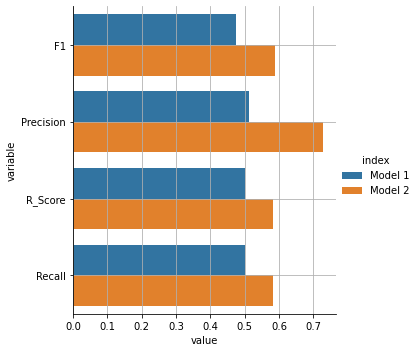

In [303]:
sns.catplot(data = scores, x = 'value', y = 'variable', hue = 'index', kind = 'bar')
plt.grid()
plt.show()

The Recursive Feature Elimination made my model even better, getting an r_score of almost 0.6 and a precision score over 0,7.